# PINN Solution of the Allen Cahn PDE

This PyTorch code demonstrates the application of physically-informed neural networks (PINN) in the solution of a well-known Allen Cahn PDE with periodic boundary condition
\begin{aligned}
  &u_t = \epsilon\Delta u - 5(u^3 - u), \quad (t, x) \in [0, T]\times[-L, L]\\
  &u(0, x) = u_0(x), \quad \forall x \in [-L, L] \\
  &u(t, -L) = u(t, L), \quad \forall t \in [0, T]
\end{aligned}
where $\epsilon > 0$ is the defintion , and $[-L, L]$ covers one full period, i.e. $T = 2L$.

## Libraries and Dependencies

In [1]:
# from the system
from itertools import chain
from collections import OrderedDict
import time
# additional computing packages
import numpy as np
import scipy as sp
import scipy.io
from scipy.interpolate import griddata
# for collocation points
from pyDOE import lhs
# for DNN training
import torch
import torch.optim
import torch.optim.lr_scheduler as lr_scheduler
# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
# set the random seed
np.random.seed(1234)

In [2]:
def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean       # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

In [3]:
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
    "pgf.preamble": r"\usepackage[utf8x]{inputenc} \usepackage[T1]{fontenc}"
    # use utf8 fonts becasue your computer can handle it :)
    # plots will be generated using this preamble
    }
mpl.rcParams.update(pgf_with_latex)

In [4]:
# MPS or CUDA or CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#
print(f"Working on {device}")

Working on mps


In [5]:
"""
Problem Definition
"""
# define grid for quadrature solution
# the following parameters and initial condition/PBC are taken from the exmaple
# in spin('GS') from chebfun
epsilon = 1e-4
L = 1.0
xlo = -L
xhi = L
period = xhi - xlo
tlo = 0.0
thi = 1.0
pi_ten = torch.tensor(np.pi).float().to(device)
L_ten = torch.tensor(L).float().to(device)
u0 = lambda x: np.power(x, 2.0) * np.cos(np.pi * x)
u0_ten = lambda x: torch.pow(x, 2.0) * torch.cos(pi_ten * x)
# please use chebfun to solve for the true solution (super easy)

## Physics-informed Neural Networks

In [6]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        # parameters
        self.depth = len(layers) - 1
        # set up layer order dict
        self.activation = torch.nn.Tanh
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
    def forward(self, x):
        out = self.layers(x)
        return out

In [7]:
# the physics-guided neural network
# we will use built-in transformation to make it 
# periodic by default
class PhysicsInformedNN():
    def __init__(self, period, m, X_PDE, layers, gamma, eta, c, epsilon):
        # Prepare the periodic layer
        m_vec = np.expand_dims(np.arange(1, m + 1), axis = 0)
        self.ms = torch.tensor(2.0 * np.pi/period * m_vec).float().to(device)
        # PDE data, gradients will be computed on these points so requires_grad = True
        self.t_PDE = torch.tensor(X_PDE[:, 0:1], requires_grad=True).float().to(device)
        self.x_PDE = torch.tensor(X_PDE[:, 1:2], requires_grad=True).float().to(device)
        N_PDE = X_PDE.shape[0]
        self.lambdas = torch.tensor(np.zeros((N_PDE, 1))).float().to(device)
        self.gamma = torch.tensor(gamma).float().to(device)
        self.eta = torch.tensor(eta).float().to(device)
        self.c = torch.tensor(c).float().to(device)     
        # layers to build Neural Net
        # changing the input variables for periodic layer
        # m cosines, m sines, and 1 costant, and 1 t
        layers[0] = int(2 * m + 2)
        self.layers = layers
        # equation related parameters
        self.epsilon = torch.tensor(epsilon).float().to(device)
        # deep neural networks
        self.dnn = DNN(layers).to(device)    
        # prepare the optimizer
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr = 1e-3)
        # add a learning rate scheduler
        self.scheduler = lr_scheduler.ExponentialLR(self.optimizer_Adam, gamma=0.99)
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-8, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )        
        self.iter = 0
    # evaluater neural network
    # with transformation to include the initial condition
    def NN_eval(self, t, x):  
        x_trans = torch.matmul(x, self.ms)
        uNN = self.dnn(torch.cat([t, torch.ones_like(x), torch.cos(x_trans), torch.sin(x_trans)], dim = 1))
        u0_torch = u0_ten(x)
        u = u0_torch + t * uNN
        return u
    # compute the PDE
    def pde_eval(self, t, x):
        """ The pytorch autograd version of calculating residual """
        u = self.NN_eval(t, x)
        # compute the derivatives for u
        u_t  = torch.autograd.grad(u,   t, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_x  = torch.autograd.grad(u,   x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        Eq  = u_t - self.epsilon * u_xx + 5.0 * (torch.pow(u, 3.0) - u)       
        return Eq
    # compute the total loss for the second-order optimizer
    # def loss_func(self):
    #     # reset the gradient
    #     self.optimizer_LBFGS.zero_grad()
    #     # compute PDE loss
    #     pde_pred = self.pde_eval(self.t_PDE, self.x_PDE)
    #     loss_PDE = torch.mean(torch.square(pde_pred))    
    #     # compute the total loss, it can be weighted
    #     loss = loss_PDE
    #     # backward propagation
    #     loss.backward()
    #     # increase the iteration counter
    #     self.iter += 1
    #     # output
    #     # output the progress
    #     if self.iter % 1000 == 0:
    #         print('Iter %5d, Total: %10.4e, PDE: %10.4e' % (self.iter, loss.item(), loss_PDE.item()))
    #     return loss
    #
    def train(self, nIter):
        # start the training with Adam first
        self.dnn.train()
        lambdas_prev = self.lambdas
        start_time = time.time()
        print('Starting with Adam')
        for epoch in range(nIter):
            # compute PDE loss
            pde_pred = self.pde_eval(self.t_PDE, self.x_PDE)
            residual = torch.abs(pde_pred)
            lambdas = self.gamma * lambdas_prev + self.eta * residual/torch.amax(residual) + self.c
            loss_PDE = torch.mean(torch.square(lambdas * pde_pred))  
            # compute the total loss, it can be weighted
            loss = loss_PDE
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step() 
            # keep 
            lambdas_prev = lambdas.clone().detach()           
            # output the progress
            if (epoch + 1) % 1000 == 0:
                end_time = time.time()
                print('Iter %5d, Total: %10.4e, PDE: %10.4e, Time: %.2f secs' 
                      % (epoch + 1, loss.item(), loss_PDE.item(), end_time - start_time))
                start_time = end_time
                # change the learning rate
                self.scheduler.step()
        # # Using the second-order L-BFGS optimizer
        # print('Starting with L-BFGS')
        # self.optimizer_LBFGS.step(self.loss_func)                
    #        
    def predict(self, X):
        t = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        x = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        u = self.NN_eval(t, x)
        u = u.detach().cpu().numpy()
        return u

## Configurations

In [8]:
# construct the points
def get_points_for_training(tlo, thi, xlo, xhi, N_PDE):
    # for collocation pts, (t, x) \in (0, T)x\Omega
    pts_rand = lhs(2, N_PDE)
    t_PDE = tlo + (thi - tlo) * pts_rand[:, 0:1]
    x_PDE = xlo + (xhi - xlo) * pts_rand[:, 1:2]
    ptsPDE = np.hstack((t_PDE, x_PDE))
    return ptsPDE

## Training

In [9]:
layers = [2, 20, 20, 20, 20, 20, 20, 20, 1]
m = 10
gamma = 0.8
eta = 1.0
c = 1.0
N_PDE = int(128 * 128)
ptsPDE = get_points_for_training(tlo, thi, xlo, xhi, N_PDE)
model = PhysicsInformedNN(period, m, ptsPDE, layers, gamma, eta, c, epsilon)
model.train(20000)

Starting with Adam


/Users/mingzhong/venv-metal/lib/python3.9/site-packages/torch/autograd/__init__.py:251: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iter  1000, Total: 6.0045e-01, PDE: 6.0045e-01, Time: 22.89 secs
Iter  2000, Total: 4.2980e-01, PDE: 4.2980e-01, Time: 23.15 secs
Iter  3000, Total: 3.7786e-01, PDE: 3.7786e-01, Time: 22.73 secs
Iter  4000, Total: 1.2235e+00, PDE: 1.2235e+00, Time: 22.75 secs
Iter  5000, Total: 3.3002e-01, PDE: 3.3002e-01, Time: 22.99 secs
Iter  6000, Total: 3.2142e-01, PDE: 3.2142e-01, Time: 22.94 secs
Iter  7000, Total: 3.5086e-01, PDE: 3.5086e-01, Time: 22.77 secs
Iter  8000, Total: 2.2925e-01, PDE: 2.2925e-01, Time: 22.73 secs
Iter  9000, Total: 2.1223e-01, PDE: 2.1223e-01, Time: 22.56 secs
Iter 10000, Total: 2.0221e-01, PDE: 2.0221e-01, Time: 22.59 secs
Iter 11000, Total: 1.9846e-01, PDE: 1.9846e-01, Time: 22.56 secs
Iter 12000, Total: 1.9412e-01, PDE: 1.9412e-01, Time: 22.63 secs
Iter 13000, Total: 1.9158e-01, PDE: 1.9158e-01, Time: 22.71 secs
Iter 14000, Total: 1.8845e-01, PDE: 1.8845e-01, Time: 22.56 secs
Iter 15000, Total: 1.8620e-01, PDE: 1.8620e-01, Time: 22.60 secs
Iter 16000, Total: 1.8392

In [10]:
# apply PINN to the same grid as the quadrature solution for comparison
t = np.linspace(tlo, thi, 101)
x = np.linspace(xlo, xhi, 101)
T, X = np.meshgrid(t, x)
pts_flat = np.hstack((T.flatten()[:, None], X.flatten()[:, None]))
u_pred = model.predict(pts_flat)
# #
# Exact = u_quad.T
# Exact_vec = Exact.flatten()[:, None]
# error_u = np.linalg.norm(Exact_vec-u_pred,2)/np.linalg.norm(Exact_vec,2)
# print('Error u: %e' % (error_u))                     
u_pred = griddata(pts_flat, u_pred.flatten(), (T, X), method='cubic')
# Error = np.abs(Exact - U_pred)

## Visualizations

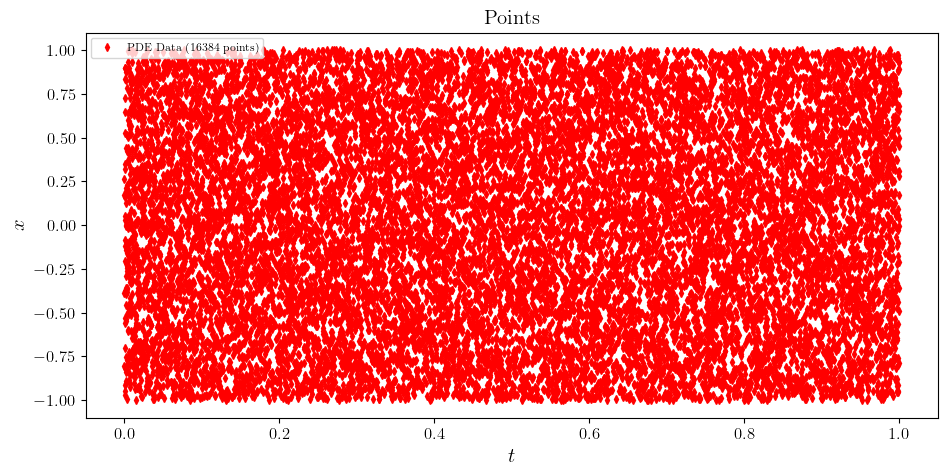

In [11]:
""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(11, 5))
ax = fig.add_subplot(1, 1, 1)
#
ax.plot(ptsPDE[:, 0], ptsPDE[:, 1], 
    'rd', label = 'PDE Data (%d points)' % (ptsPDE.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)
#
ax.set_xlabel('$t$', size=15)
ax.set_ylabel('$x$', size=15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.legend()
ax.set_title('Points', fontsize = 15) # font size doubled
ax.tick_params(labelsize=12)
#
plt.show()

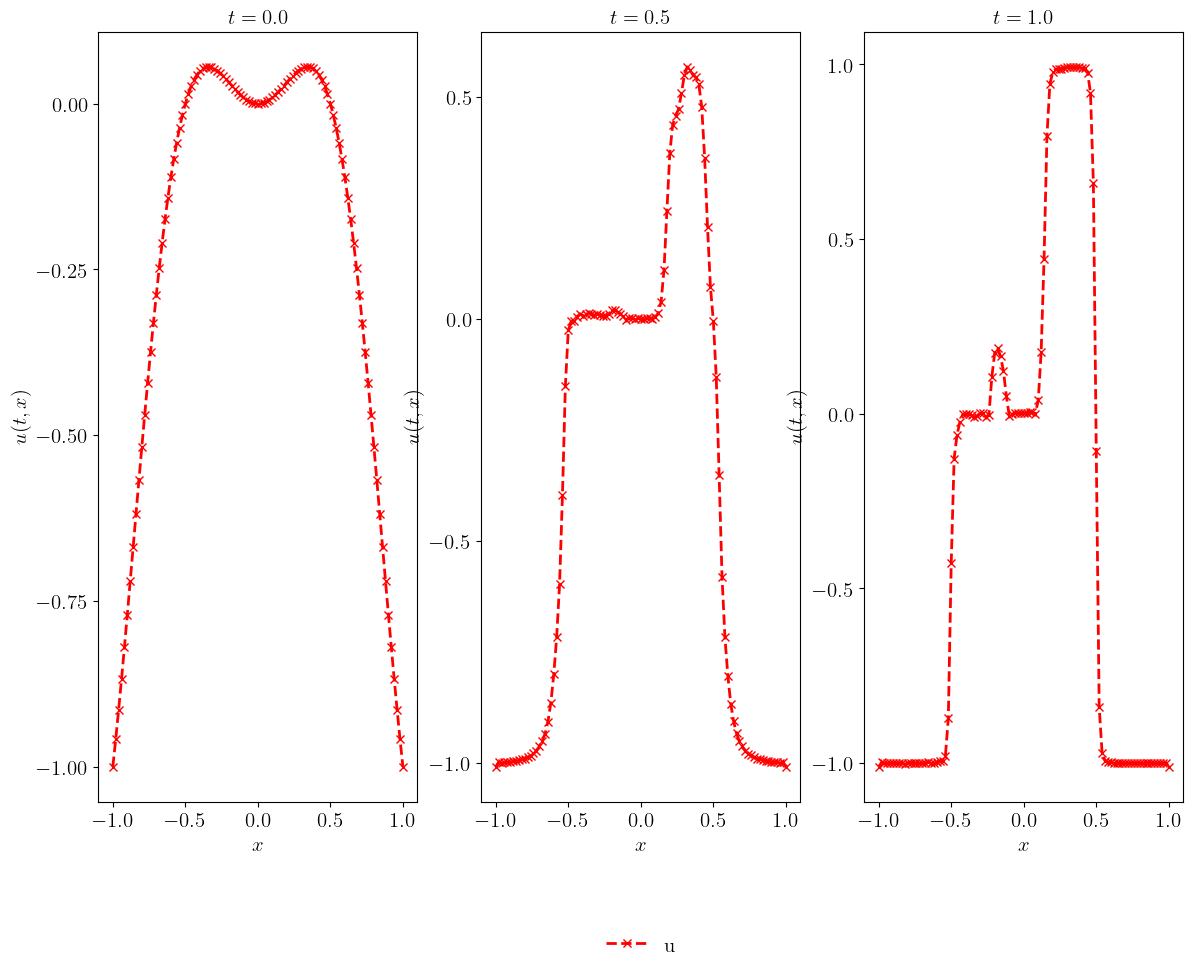

In [12]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
#
ax = plt.subplot(1, 3, 1)
#ax.plot(x, Exact[:, 25], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 0], 'rx--', linewidth = 2, label = 'u')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = %.1f$' %(t[0]), fontsize = 15)
#ax.axis('square')
# ax.set_xlim([-0.1,1.1])
# ax.set_ylim([-0.1,1.1]) 
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(1, 3, 2)
#ax.plot(x,Exact[:,50], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 50], 'rx--', linewidth = 2, label = 'u')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
#ax.axis('square')
# ax.set_xlim([-L,L])
# ax.set_ylim([-0.1,1.1]) 
ax.set_title('$t = %.1f$' %(t[50]), fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(1, 3, 3)
#ax.plot(x,Exact[:,75], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 100], 'rx--', linewidth = 2, label = 'u')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
#ax.axis('square')
# ax.set_xlim([-0.1,1.1])
# ax.set_ylim([-0.1,1.1])    
ax.set_title('$t = %.1f$' %(t[100]), fontsize = 15)
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()